In [1]:
import sys
import re
import datetime
import numpy as np
import pandas as pd
from numpy import dot
from numpy.linalg import norm
from pyspark import *
from pyspark.sql import *
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType, StringType, ArrayType, StructType, StructField, FloatType, DoubleType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.ml.regression import LinearRegression
import matplotlib.pyplot as plt

In [2]:
sc.stop()
spark = SparkSession.builder.appName('haha').getOrCreate()

In [3]:
rawdata = spark.read.option('header','true').option('inferSchema','true').csv('mobile_coverage.csv')

In [4]:
rawdata.show()

+-------------------+-------------------+---------+---------+------+-------+--------+------+--------------------+---+-----+----------+----------+--------+----------+-------------+-----------+-----------+---------+
|               date|               hour|      lat|     long|signal|network|operator|status|         description|net|speed|satellites|precission|provider|  activity|downloadSpeed|uploadSpeed|postal_code|town_name|
+-------------------+-------------------+---------+---------+------+-------+--------+------+--------------------+---+-----+----------+----------+--------+----------+-------------+-----------+-----------+---------+
|2016-01-16 00:00:00|2023-04-21 16:55:40|  10.5578|-83.51559|     2|   null|    null|     0|    STATE_IN_SERVICE| 3G| 14.7|       4.0|     128.0|     gps|IN_VEHICLE|         null|       null|       null|     null|
|2016-05-15 00:00:00|2023-04-21 17:30:06| 42.58326|  1.66264|     3|   null|    null|     0|    STATE_IN_SERVICE| 2G|  0.0|       2.0|      17.0

In [5]:
rawdata.groupby('status','description').agg(F.count(F.col('date'))).collect()

[Row(status=0, description='STATE_IN_SERVICE', count(date)=1313787),
 Row(status=3, description='STATE_POWER_OFF', count(date)=29676),
 Row(status=2, description='STATE_EMERGENCY_ONLY', count(date)=10401304),
 Row(status=1, description='STATE_OUT_OF_SERVICE', count(date)=147)]

In [6]:
data_1 = rawdata.select(F.substring('date',6,2).cast(IntegerType()).alias('month'),'signal')
data_1.show()

+-----+------+
|month|signal|
+-----+------+
|    1|     2|
|    5|     3|
|   12|    11|
|    1|    24|
|    1|    17|
|    7|    31|
|   12|    14|
|   12|    10|
|    9|     8|
|    3|    15|
|    7|    20|
|    4|    29|
|   11|    10|
|   12|    21|
|   12|     1|
|   10|    15|
|    3|    16|
|    4|    12|
|    6|    14|
|    6|     6|
+-----+------+
only showing top 20 rows



In [7]:
assembler = VectorAssembler(inputCols=["month", "signal"], outputCol="features")
df_vector = assembler.transform(data_1)
correlation_matrix = Correlation.corr(df_vector, "features", "pearson")
correlation_matrix.collect()

23/04/21 16:05:03 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/04/21 16:05:03 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
23/04/21 16:05:03 WARN InstanceBuilder$JavaBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


[Row(pearson(features)=DenseMatrix(2, 2, [1.0, -0.0121, -0.0121, 1.0], False))]

In [8]:
rawdata.select('activity').distinct().collect()

[Row(activity='IN_VEHICLE'),
 Row(activity='TILTING'),
 Row(activity='ON_FOOT'),
 Row(activity=None),
 Row(activity='UNKNOWN'),
 Row(activity='STILL'),
 Row(activity='ON_BICYCLE')]

In [9]:
rawdata.groupBy('activity').agg(F.avg('speed')).collect()

[Row(activity='IN_VEHICLE', avg(speed)=46.27297957912117),
 Row(activity='TILTING', avg(speed)=8.43970966550125),
 Row(activity='ON_FOOT', avg(speed)=4.491999974896098),
 Row(activity=None, avg(speed)=18.418592978899998),
 Row(activity='UNKNOWN', avg(speed)=6.704919717837404),
 Row(activity='STILL', avg(speed)=7.418260140887934),
 Row(activity='ON_BICYCLE', avg(speed)=17.71270950437317)]

In [10]:
data_2 = rawdata.select(F.col('speed').alias('y'),F.when(F.col('activity')=='IN_VEHICLE',1).otherwise(0).alias('V'),
                       F.when(F.col('activity')=='ON_FOOT',1).otherwise(0).alias('F'),
                       F.when(F.col('activity')=='ON_BICYCLE',1).otherwise(0).alias('B'),
                       F.when(F.col('activity')=='STILL',1).otherwise(0).alias('S'))
assembler = VectorAssembler(outputCol="features")
assembler.setInputCols(["V", "F", "B"])
df = assembler.transform(data_2.filter(F.col("V")+F.col("F")+F.col("B")+F.col("S")>0))
lr = LinearRegression(featuresCol="features", labelCol="y")
model = lr.fit(df)
print("Coefficients: " + str(model.coefficients))
print("Intercept: " + str(model.intercept))

23/04/21 16:05:14 WARN Instrumentation: [cf96d013] regParam is zero, which might cause numerical instability and overfitting.


23/04/21 16:05:19 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Coefficients: [38.85471943820712,-2.9262601660179683,10.294449363459108]
Intercept: 7.418260140914065


In [11]:
data_2 = rawdata.select(F.col('signal').alias('y'),F.when(F.col('status')==0,1).otherwise(0).alias('0'),
                       F.when(F.col('status')==1,1).otherwise(0).alias('1'),
                       F.when(F.col('status')==2,1).otherwise(0).alias('2'),
                       F.when(F.col('status')==3,1).otherwise(0).alias('3'))
assembler = VectorAssembler(outputCol="features")
assembler.setInputCols(["0", "2", "3"])
df = assembler.transform(data_2.filter(F.col("2")+F.col("3")+F.col("0")>0).filter(F.col('speed')>0))
df.show()

+---+---+---+---+---+-------------+
|  y|  0|  1|  2|  3|     features|
+---+---+---+---+---+-------------+
|  2|  1|  0|  0|  0|[1.0,0.0,0.0]|
| 11|  0|  0|  1|  0|[0.0,1.0,0.0]|
| 24|  1|  0|  0|  0|[1.0,0.0,0.0]|
| 31|  1|  0|  0|  0|[1.0,0.0,0.0]|
| 14|  0|  0|  1|  0|[0.0,1.0,0.0]|
| 10|  0|  0|  1|  0|[0.0,1.0,0.0]|
|  8|  0|  0|  1|  0|[0.0,1.0,0.0]|
| 15|  0|  0|  1|  0|[0.0,1.0,0.0]|
| 20|  1|  0|  0|  0|[1.0,0.0,0.0]|
| 29|  1|  0|  0|  0|[1.0,0.0,0.0]|
| 10|  1|  0|  0|  0|[1.0,0.0,0.0]|
| 21|  0|  0|  1|  0|[0.0,1.0,0.0]|
|  1|  0|  0|  1|  0|[0.0,1.0,0.0]|
| 15|  1|  0|  0|  0|[1.0,0.0,0.0]|
| 16|  0|  0|  1|  0|[0.0,1.0,0.0]|
| 12|  1|  0|  0|  0|[1.0,0.0,0.0]|
| 14|  1|  0|  0|  0|[1.0,0.0,0.0]|
| 13|  1|  0|  0|  0|[1.0,0.0,0.0]|
|  5|  0|  0|  1|  0|[0.0,1.0,0.0]|
| 15|  1|  0|  0|  0|[1.0,0.0,0.0]|
+---+---+---+---+---+-------------+
only showing top 20 rows



In [12]:
result = rawdata.groupby('status','signal').agg(F.count('date').alias('num')).toPandas()
result

,status,signal,num
0,3,22,597
1,3,15,1335
2,3,30,134
3,0,25,16420
4,0,57,595
...,...,...,...
221,2,87,3
222,2,86,1
223,1,56,1
224,1,2,1


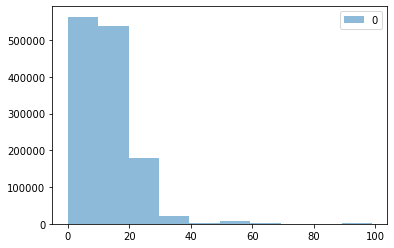

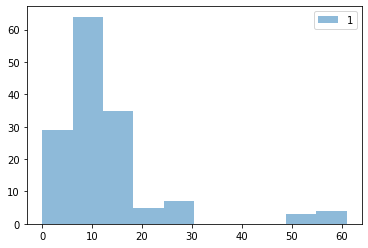

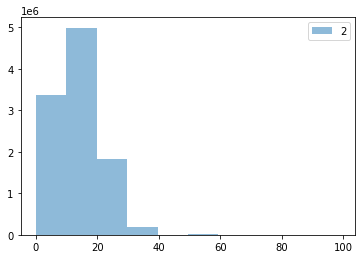

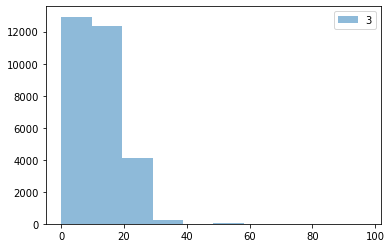

In [13]:
for i in range(4):
    data_plt = result[result['status']==i]
    plt.hist(data_plt['signal'], weights=data_plt['num'], bins=10, alpha=0.5, label=i)
    plt.legend()
    plt.show()


In [14]:
lr = LinearRegression(featuresCol="features", labelCol="y")
model = lr.fit(df)
print("Coefficients: " + str(model.coefficients))
print("Intercept: " + str(model.intercept))

23/04/21 16:05:27 WARN Instrumentation: [472c070d] regParam is zero, which might cause numerical instability and overfitting.


23/04/21 16:05:31 WARN Instrumentation: [472c070d] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Coefficients: [-0.7261159687399789,0.7570343635766049,-1.6335069189673879]
Intercept: 12.640077124194004
